This notebook is designed to teach the basics of least-squares linear fitting, a handy method for very quickly determining the exact best-fit parameters for a certain class of models given a dataset.  This tutorial will create a toy problem and walk through the process of writing a simple least squares linear fit algorithm to determine credible values of the parameters based on the data at hand. This tutorial closely follows the excellent <a href='https://github.com/avanderburg/leastsquarestutorial/blob/main/Heiles_least_squares_fitting_2008.pdf'>least-squares fitting manual</a> written by Carl Heiles. 

We will start by importing two handy packages: numpy for array mathematics and a variety of other useful tools, and matplotlib to help us visualize the problem and what the linear fitter is doing.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now, let's create a toy dataset. Let's generate data with a very simple model (a straight line), with only two parameters: a slope and a y-intercept. In particular, the equation of our line is:

y = intercept + slope * x 


In [2]:
x = np.linspace(0, 10, 30)# generate an evenly sampled X axis (not strictly necessary for this problem). 

In [3]:
slope_true = 1.5
intercept_true = 4
uncertainty_true = 1 # These parameters are the "truth" that our least-squares linear fit will try to recover.  

In [4]:
y = intercept_true + slope_true * x  #Calculate the y values based on the linear model
y = y + np.random.normal(0, uncertainty_true, len(x)) #and add some random noise with
#a Gaussian distribution centered on 0, with a standard deviation of 1. 
err = np.ones_like(y) * uncertainty_true

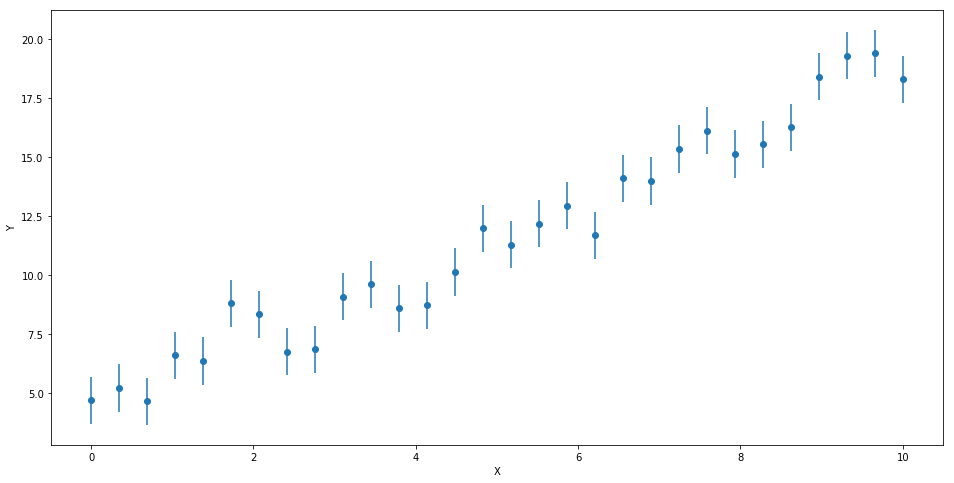

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(x, y, yerr = np.ones_like(y) * uncertainty_true, fmt = 'o')
ax.set_ylabel('Y');
ax.set_xlabel('X');

Now that we have created a test dataset, we can start to set up the linear least squares problem. The basic idea is that if we can describe the dataset as a sum of a set of scaled vectors, we can write down and solve a set of equations that give the best scaling factors for each vector. In this case, we have good reason to believe that the dataset can be described as a sum of two vectors: one constant (y-intercept) and one line (slope * x value). That is, the equation we used to generate the line:

y = intercept + slope * x

can be written as:

y = C<sub>1</sub> * V<sub>1</sub> + C<sub>2</sub> * V<sub>2</sub> 

where C<sub>1</sub> is the Y-intercept, C<sub>2</sub> is the slope, V<sub>1</sub> is the vector[1,1,1,...1,1,1], and V<sub>2</sub> is the vector [x[0], x[1], x[2],...x[27], x[28], x[29]]. 

Let's go ahead and create the vectors V<sub>1</sub> and V<sub>2</sub> in our code. 

In [6]:
v1 = np.zeros_like(x) + 1
print('V1 = ', v1,'\n')
v2 = np.copy(x)
print('V2 = ', v2)

V1 =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.] 

V2 =  [ 0.          0.34482759  0.68965517  1.03448276  1.37931034  1.72413793
  2.06896552  2.4137931   2.75862069  3.10344828  3.44827586  3.79310345
  4.13793103  4.48275862  4.82758621  5.17241379  5.51724138  5.86206897
  6.20689655  6.55172414  6.89655172  7.24137931  7.5862069   7.93103448
  8.27586207  8.62068966  8.96551724  9.31034483  9.65517241 10.        ]


Let's plot these two vectors: 

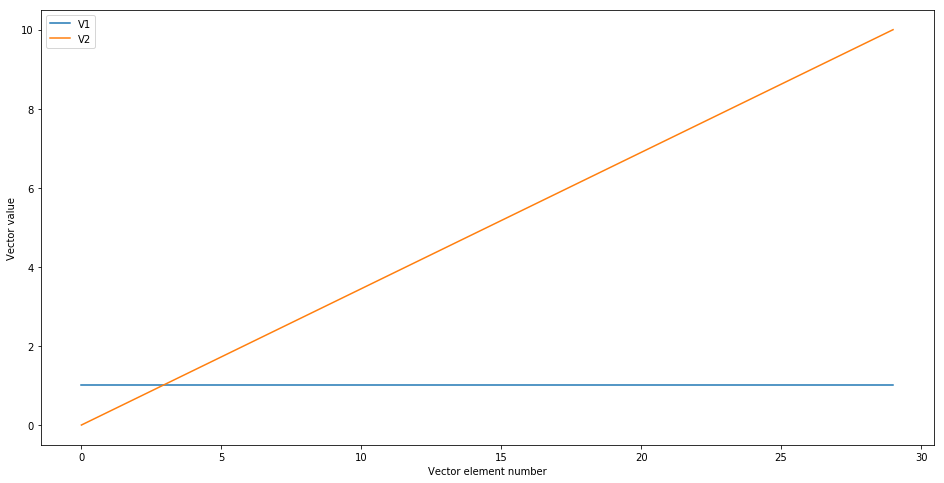

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(v1,  label = 'V1',zorder=1)
plt.plot(v2,  label = 'V2',zorder=1)

ax.set_ylabel('Vector value');
ax.set_xlabel('Vector element number');
l=plt.legend(loc=2)


Now that we have generated the vectors we will use to fit the dataset, let's take a quick look at the math. As described in the Heiles least-squares fitting manual, we will seek to solve the matrix equation: 

In [8]:
Xmat = np.stack((v1, v2)).transpose()
Ymat = y.reshape(len(y),1)
print('Xmat = \n',Xmat)
print('\nYmat = \n', Ymat)

Xmat = 
 [[ 1.          0.        ]
 [ 1.          0.34482759]
 [ 1.          0.68965517]
 [ 1.          1.03448276]
 [ 1.          1.37931034]
 [ 1.          1.72413793]
 [ 1.          2.06896552]
 [ 1.          2.4137931 ]
 [ 1.          2.75862069]
 [ 1.          3.10344828]
 [ 1.          3.44827586]
 [ 1.          3.79310345]
 [ 1.          4.13793103]
 [ 1.          4.48275862]
 [ 1.          4.82758621]
 [ 1.          5.17241379]
 [ 1.          5.51724138]
 [ 1.          5.86206897]
 [ 1.          6.20689655]
 [ 1.          6.55172414]
 [ 1.          6.89655172]
 [ 1.          7.24137931]
 [ 1.          7.5862069 ]
 [ 1.          7.93103448]
 [ 1.          8.27586207]
 [ 1.          8.62068966]
 [ 1.          8.96551724]
 [ 1.          9.31034483]
 [ 1.          9.65517241]
 [ 1.         10.        ]]

Ymat = 
 [[ 4.68476076]
 [ 5.20946031]
 [ 4.64174855]
 [ 6.59624503]
 [ 6.35490827]
 [ 8.8003945 ]
 [ 8.34005096]
 [ 6.75101414]
 [ 6.85270169]
 [ 9.07603793]
 [ 9.60909225]
 [ 8.

Now that we have created these matrices, we can use linear algebra to solve for the best fit coefficients. The math is described in detail in Heiles Sections 2 and 3. Note that this treatment assumes that the uncertainties on the datapoints are <i> all uniform </i> and <i> equal to the scatter about the best-fit model</i>. It is possible to relax these assumptions, as discussed in Heiles Section 8.

Note also that the @ symbol is Python 3's shorthand for matrix multiplication. If you wish to replicate this in Python 2, you will need to use <a href='https://numpy.org/doc/stable/reference/generated/numpy.matmul.html'>numpy's matrix multiplication function</a>. 

In [9]:
alphamat = Xmat.transpose() @ Xmat
betamat = Xmat.transpose() @ Ymat
alphainv = np.linalg.inv(alphamat)
coeff = alphainv @ betamat
print(coeff)

[[4.25044472]
 [1.45826405]]


You can calculate the best fit model now by taking these parameters and multiplying them by the vectors: 

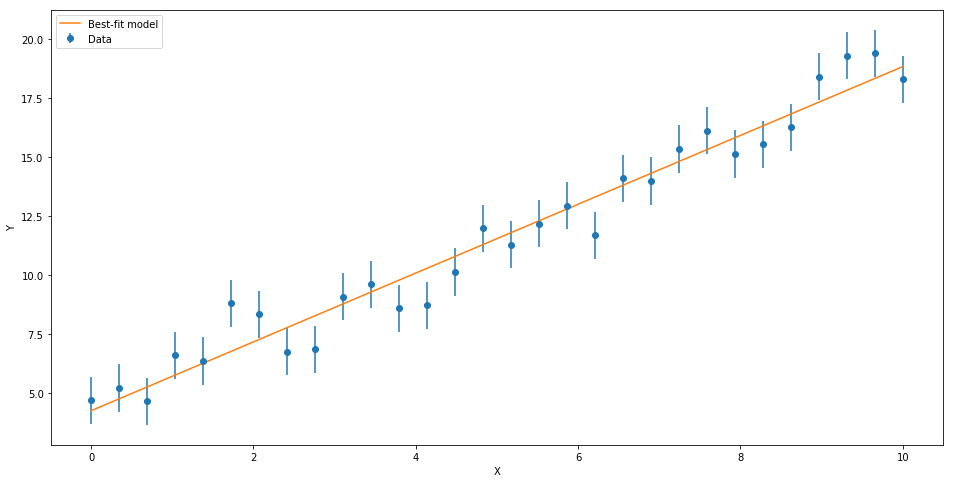

In [10]:
bestfitmodel = coeff[0] * v1 + coeff[1] * v2

fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(x, y, yerr = np.ones_like(y) * uncertainty_true, fmt = 'o', label = 'Data')
ax.set_ylabel('Y');
ax.set_xlabel('X');


plt.plot(x, bestfitmodel, label = 'Best-fit model')
l=plt.legend(loc=2)

An equivalent way to calculate the best-fit model (easier to implement when you have a large number of free parameters) is:

In [11]:
bestfitmodel2 = Xmat @ coeff

The uncertainties on the coefficients can be calculated as:

In [12]:
residuals = Ymat - bestfitmodel2
ssq = float(1/(len(y) - Xmat.shape[1]) * (residuals.transpose()@ residuals))#This is the estimated 
#variance of each datapoint
sigma_coeff = np.sqrt(ssq * np.diag(alphainv))
print(sigma_coeff)

[0.33651721 0.05779043]


So this procedure gives the following values and uncertainties for the slope and intercept: 

In [13]:
print('Slope = ', float(coeff[1]), '+/-', sigma_coeff[1])
print('Intercept = ', float(coeff[0]), '+/-', sigma_coeff[0])

Slope =  1.458264046718952 +/- 0.057790425603419834
Intercept =  4.250444722361756 +/- 0.33651720609290475


Note that these parameters and uncertainties are very similar to those derived from the much more computationally intensive <a href='https://github.com/avanderburg/MCMC-tutorial/blob/master/mcmctutorial.ipynb'>Markov Chain Monte Carlo</a> solution to this exact same problem. For linear models, exact least squares fitting can give very good resutls with a fraction of the computational cost.  

Linear least squares can be used to exactly solve for coefficients of linear models (that is, models that can be described as a sum of some number of scaled vectors) with larger numbers of more complex vectors than those seen here. For example, consider the case of trying to measure the amplitude of a stellar flare on a star with starspots rotating in and out of view. 

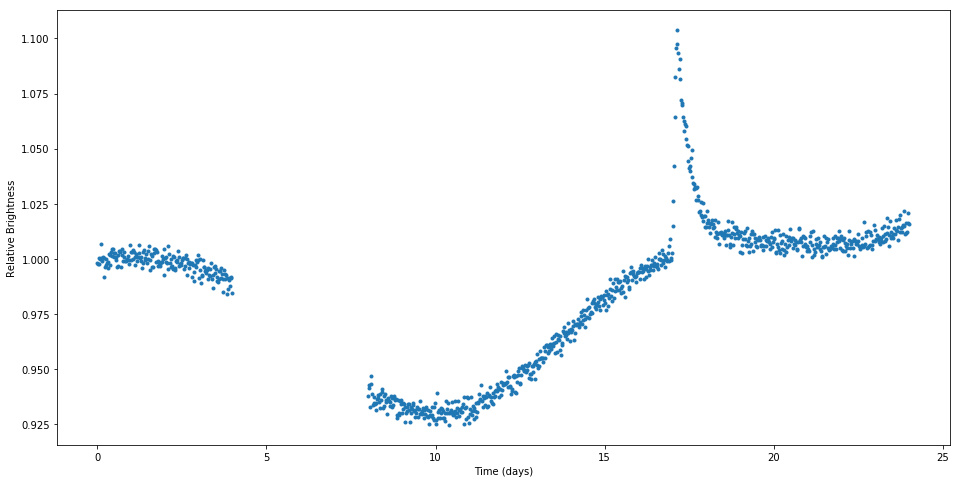

In [14]:
t = np.linspace(0, 20, 1000)
t[200:] = t[200:] + 4
f = 0.02 * np.sin(2 * np.pi * t / (13.4)) + np.random.normal(1, 0.003, len(t)) -0.05 * np.sin(2 * np.pi * t / (38.4))
def flarefunction(t, starttime, amplitude, decay, risefraction):
    y = np.zeros_like(t)
    risetime = decay * risefraction
    y[np.logical_and(t>starttime, t < starttime + risetime)] = (t[np.logical_and(t>starttime, t < starttime + risetime)] - starttime) * amplitude/risetime
    y[t>starttime + risetime] = amplitude * np.exp(-1*(t[t>starttime + risetime]-starttime-risetime)/decay)
    return y
    
fig, ax = plt.subplots(figsize=(16, 8))

flareamplitudetrue = 0.1

flare = flarefunction(t, 17, flareamplitudetrue, .4, .3)
f = f + flare
plt.plot(t, f,'.')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)');

Suppose we know that a flare took place at time = 17 days and we know the rise time and decay time from other observations. We can use linear least squares to estimate the amplitude of the flare from these observations. To do this, we create several vectors: some to describe the slow variations due to starspots rotating in and out of view, and one to describe the flare. 

In [15]:
#We can describe the flare with a model calculated using the flarefunction with amplitude = 1, 
#and the correct start time, rise time, and ecay times from our other measurements. 
v0 = flarefunction(t, 17, 1, .4, .3)

#And we can describe the slow variations with an 8th order polynomial. Note that this is not exactly how the
#variations were simulated above (a sum of several sinusoids), but the polynomial should model them well. If
#we wanted to, we could have used sinusoids in the linear fit as well. 
v1 = np.zeros_like(t) + 1
v2 = np.copy(t)
v3 = t**2
v4 = t**3
v5 = t**4
v6 = t**5
v7 = t**6
v8 = t**7
v9 = t**8




Now, we can do the same matrix algebra to get best-fit coefficients and the best-fit model: 

Flare Amplitude =  0.10077761735010426 +/- 0.006859585120707437 , compared to a true value of  0.1 .


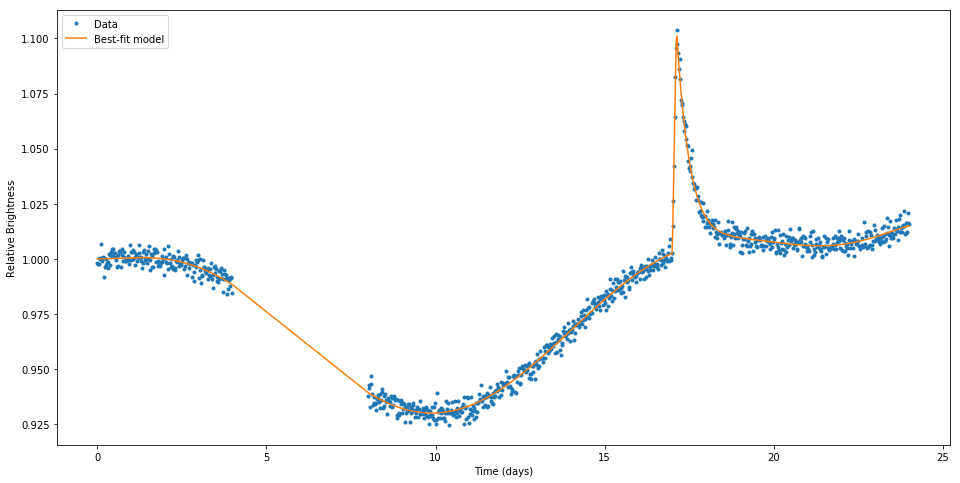

In [16]:
Xmat = np.stack((v0, v1, v2, v3, v4, v5, v6, v7, v8, v9)).transpose()
Ymat = f.reshape(len(f),1)
alphamat = Xmat.transpose() @ Xmat
betamat = Xmat.transpose() @ Ymat
alphainv = np.linalg.inv(alphamat)
coeff = alphainv @ betamat
bestfitmodel = Xmat @ coeff
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(t, f,'.', label = 'Data')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)')

plt.plot(t, bestfitmodel, label = 'Best-fit model')
l=plt.legend(loc=2)

residuals = Ymat - bestfitmodel
ssq = float(1/(len(y) - Xmat.shape[1]) * (residuals.transpose()@ residuals))#This is the estimated 
#variance of each datapoint
sigma_coeff = np.sqrt(ssq * np.diag(alphainv))


print('Flare Amplitude = ',float(coeff[0]),'+/-',sigma_coeff[0],', compared to a true value of '
      ,flareamplitudetrue,'.')


We can get similar results using fewer free parametersby modeling the slow variations as sinusoids (as we would expect since that is how they were generated originally): 

Flare Amplitude =  0.10143280893324336 +/- 0.0059989276107728475 , compared to a true value of  0.1 .


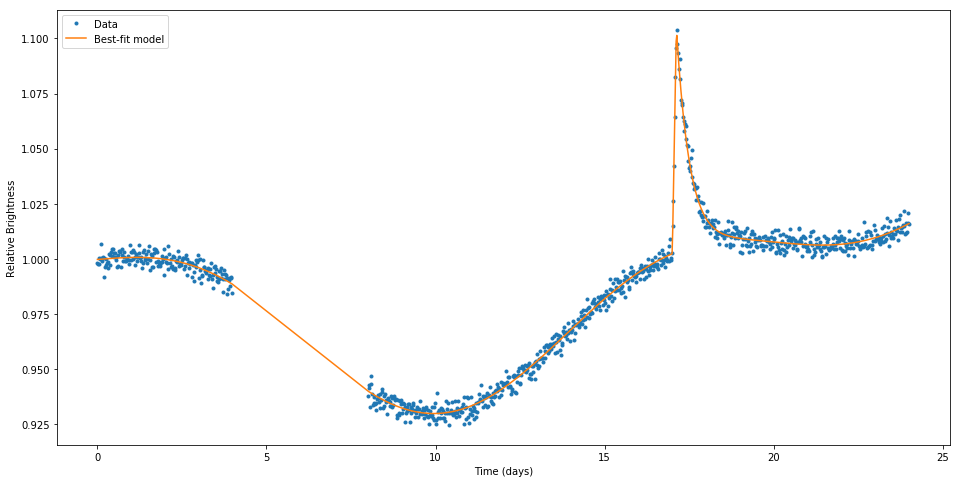

In [17]:
#We can describe the flare with a model calculated using the flarefunction with amplitude = 1, 
#and the correct start time, rise time, and ecay times from our other measurements. 
v0 = flarefunction(t, 17, 1, .4, .3)

#And we can describe the slow variations with a sum of two sinusoids. We have to specify the
# since the period cannot be adjusted, but the phase can be fit linearly by fitting for a sine and cosine
#for each periodicity.

v1 = np.zeros_like(t) + 1
v2 = np.sin(2 * np.pi * t / (13.4))
v3 = np.sin(2 * np.pi * t / (38.4))
v4 = np.cos(2 * np.pi * t / (13.4))
v5 = np.cos(2 * np.pi * t / (38.4))

Xmat = np.stack((v0, v1, v2, v3, v4, v5)).transpose()
Ymat = f.reshape(len(f),1)
alphamat = Xmat.transpose() @ Xmat
betamat = Xmat.transpose() @ Ymat
alphainv = np.linalg.inv(alphamat)
coeff = alphainv @ betamat
bestfitmodel = Xmat @ coeff
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(t, f,'.', label = 'Data')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)')

plt.plot(t, bestfitmodel, label = 'Best-fit model')
l=plt.legend(loc=2)

residuals = Ymat - bestfitmodel
ssq = float(1/(len(y) - Xmat.shape[1]) * (residuals.transpose()@ residuals))#This is the estimated 
#variance of each datapoint
sigma_coeff = np.sqrt(ssq * np.diag(alphainv))


print('Flare Amplitude = ',float(coeff[0]),'+/-',sigma_coeff[0],', compared to a true value of '
      ,flareamplitudetrue,'.')

What happens if some of your datapoints are bad? For example, imagine that a cloud briefly passed in front of the star and caused your data to be noisy for a few minutes (right during the flare!). Your dataset might look something like this: 

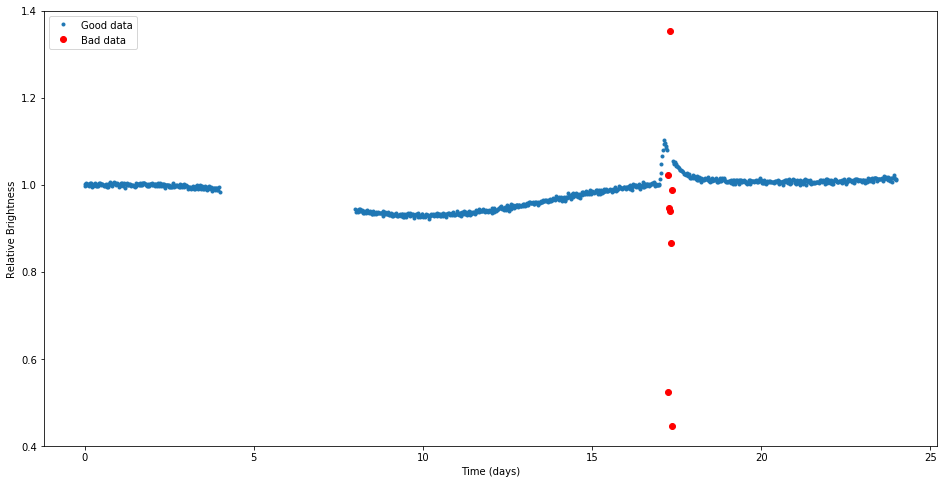

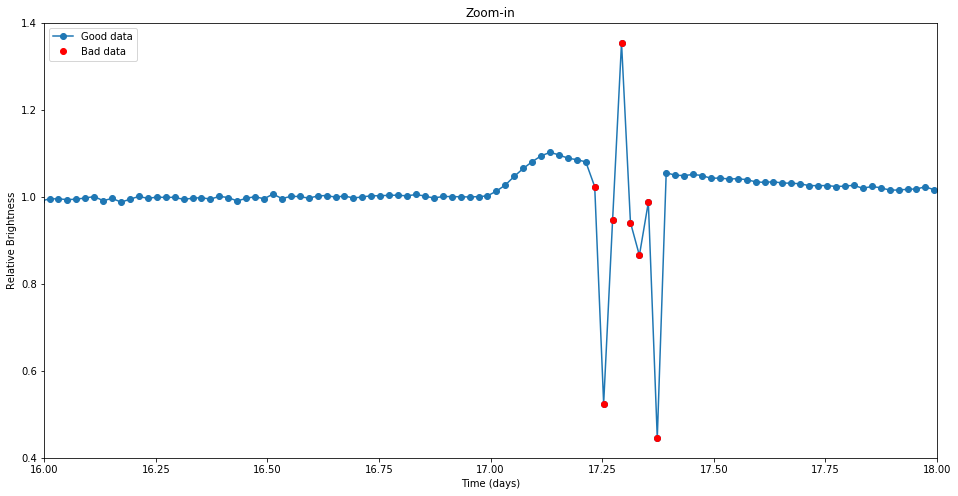

In [18]:
t = np.linspace(0, 20, 1000)
t[200:] = t[200:] + 4
f = 0.02 * np.sin(2 * np.pi * t / (13.4)) -0.05 * np.sin(2 * np.pi * t / (38.4))
f[abs(t-17.3) > .08] = f[abs(t-17.3) > .08] + np.random.normal(1, 0.003, len(t[abs(t-17.3) > .08]))
f[abs(t-17.3) <= .08] = f[abs(t-17.3) <= .08] + np.random.normal(.8, 0.3, len(t[abs(t-17.3) <= .08]))

def flarefunction(t, starttime, amplitude, decay, risefraction):
    y = np.zeros_like(t)
    risetime = decay * risefraction
    y[np.logical_and(t>starttime, t < starttime + risetime)] = (t[np.logical_and(t>starttime, t < starttime + risetime)] - starttime) * amplitude/risetime
    y[t>starttime + risetime] = amplitude * np.exp(-1*(t[t>starttime + risetime]-starttime-risetime)/decay)
    return y
   
flareamplitudetrue = 0.1

flare = flarefunction(t, 17, flareamplitudetrue, .4, .3)
f = f + flare


fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(t, f,'.', label = 'Good data')
plt.plot(t[abs(t-17.3) <= .08], f[abs(t-17.3) <= .08], 'or', label='Bad data')

ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)')
l=plt.legend(loc=2)
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(t, f,'o-', label = 'Good data')
plt.plot(t[abs(t-17.3) <= .08], f[abs(t-17.3) <= .08], 'or', label='Bad data')
plt.xlim(16, 18)
plt.title('Zoom-in')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)');
l=plt.legend(loc=2)

If we try a naive least-squares fit without compensating for this bad data in any way, the measured amplitude of the flare is significantly different from the input.

Flare Amplitude =  0.022043807238248725 +/- 0.05710992708707026 , compared to a true value of  0.1 .


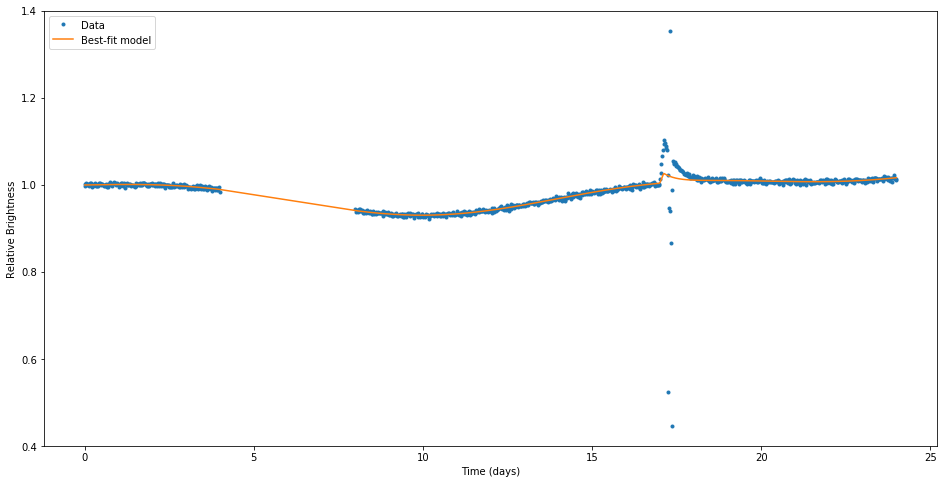

In [19]:
#We can describe the flare with a model calculated using the flarefunction with amplitude = 1, 
#and the correct start time, rise time, and ecay times from our other measurements. 
v0 = flarefunction(t, 17, 1, .4, .3)

#And we can describe the slow variations with a sum of two sinusoids. We have to specify the
# since the period cannot be adjusted, but the phase can be fit linearly by fitting for a sine and cosine
#for each periodicity.

v1 = np.zeros_like(t) + 1
v2 = np.sin(2 * np.pi * t / (13.4))
v3 = np.sin(2 * np.pi * t / (38.4))
v4 = np.cos(2 * np.pi * t / (13.4))
v5 = np.cos(2 * np.pi * t / (38.4))

Xmat = np.stack((v0, v1, v2, v3, v4, v5)).transpose()
Ymat = f.reshape(len(f),1)
alphamat = Xmat.transpose() @ Xmat
betamat = Xmat.transpose() @ Ymat
alphainv = np.linalg.inv(alphamat)
coeff = alphainv @ betamat
bestfitmodel = Xmat @ coeff
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(t, f,'.', label = 'Data')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)')

plt.plot(t, bestfitmodel, label = 'Best-fit model')
l=plt.legend(loc=2)

residuals = Ymat - bestfitmodel
ssq = float(1/(len(y) - Xmat.shape[1]) * (residuals.transpose()@ residuals))#This is the estimated 
#variance of each datapoint
sigma_coeff = np.sqrt(ssq * np.diag(alphainv))


print('Flare Amplitude = ',float(coeff[0]),'+/-',sigma_coeff[0],', compared to a true value of '
      ,flareamplitudetrue,'.')

We can solve this problem by using weighted least-squares fitting, or 𝛘<sup>2</sup> ("chi squared") fitting. The setup for this problem is very similar to least-squares fitting, but we also input an array of uncertainties for the datapoints. In this example, we call that array "<i>err</i>" and assign small uncertainties to the good datapoints, and much larger uncertainties to the datapoints affected by clouds. 

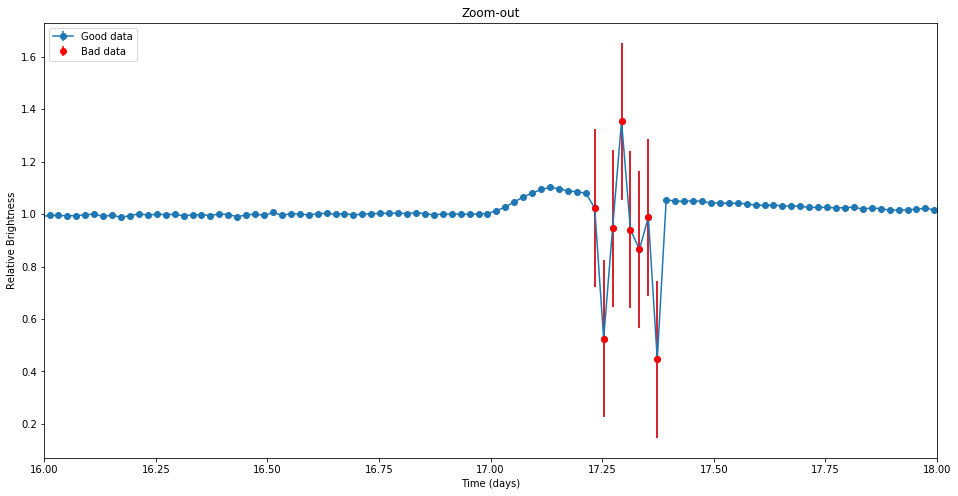

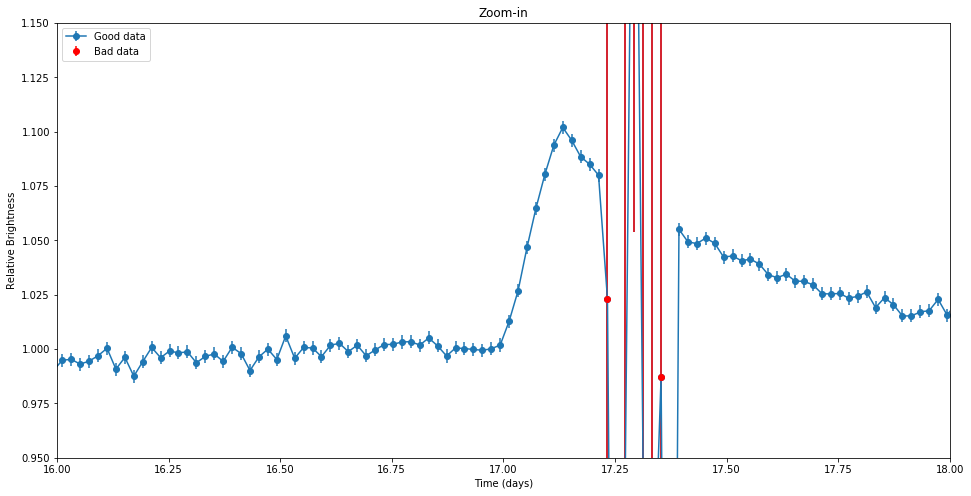

In [20]:
err = np.zeros_like(f)
err[abs(t-17.3) > .08] = 0.003
err[abs(t-17.3) <= .08] = 0.3

fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(t, f, yerr=err,fmt='o-', label = 'Good data')
plt.errorbar(t[abs(t-17.3) <= .08], f[abs(t-17.3) <= .08], yerr=err[abs(t-17.3) <= .08], fmt='or', label='Bad data')
plt.xlim(16, 18)
plt.title('Zoom-out')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)')
l=plt.legend(loc=2)

fig, ax = plt.subplots(figsize=(16, 8))

plt.errorbar(t, f, yerr=err,fmt='o-', label = 'Good data')
plt.errorbar(t[abs(t-17.3) <= .08], f[abs(t-17.3) <= .08], yerr=err[abs(t-17.3) <= .08], fmt='or', label='Bad data')
plt.xlim(16, 18)
plt.title('Zoom-in')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)')
plt.ylim(0.95, 1.15)
l=plt.legend(loc=2)

A slight modification to the original least-squares fitting code incorporates these uncertainties. 

Flare Amplitude =  0.09879225969931327 +/- 0.006881722567048337 , compared to a true value of  0.1 .


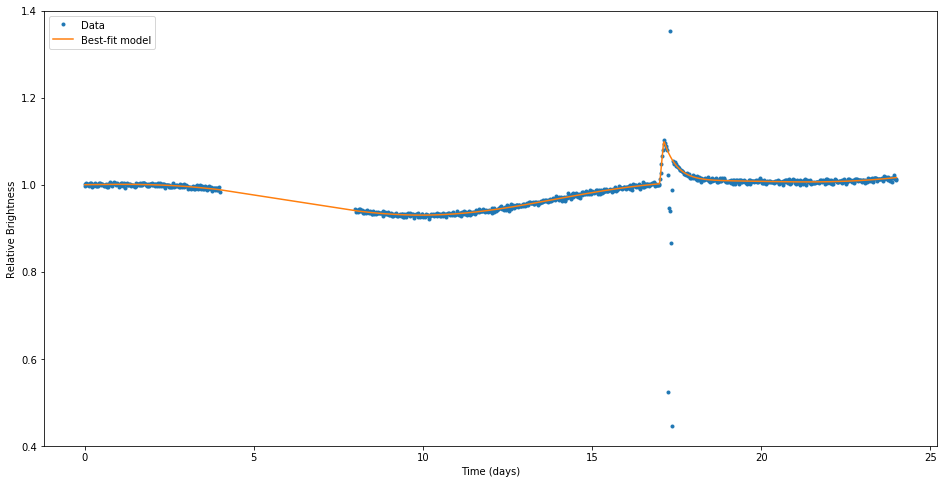

In [21]:
#We can describe the flare with a model calculated using the flarefunction with amplitude = 1, 
#and the correct start time, rise time, and ecay times from our other measurements. 
v0 = flarefunction(t, 17, 1, .4, .3)

#And we can describe the slow variations with a sum of two sinusoids. We have to specify the
# since the period cannot be adjusted, but the phase can be fit linearly by fitting for a sine and cosine
#for each periodicity.

v1 = np.zeros_like(t) + 1
v2 = np.sin(2 * np.pi * t / (13.4))
v3 = np.sin(2 * np.pi * t / (38.4))
v4 = np.cos(2 * np.pi * t / (13.4))
v5 = np.cos(2 * np.pi * t / (38.4))


###### Begin new code ####
invsigma = np.identity(len(err)) * 1/err #create a matrix with the 1/uncertainties 
#for each datapoint on the diagonal
Xmatorig = np.stack((v0, v1, v2, v3, v4, v5)).transpose() #save this for later, when we
#calculate the best-fit model
Xmat = invsigma @ np.stack((v0, v1, v2, v3, v4, v5)).transpose() #Multiply inverse sigma array by the X
Ymat = invsigma @ f.reshape(len(f),1) #and Y matrices, and then do the rest of the calculation analogously. 
#### End new code ####



alphamat = Xmat.transpose() @ Xmat
betamat = Xmat.transpose() @ Ymat
alphainv = np.linalg.inv(alphamat)
coeff = alphainv @ betamat

###### Begin new code ####
bestfitmodel = Xmatorig @ coeff # To get the best-fit model for plotting purposes, we need to multiply by
#the old definition of the X matrix, before multiplying by the inverse uncertainties. 
###### End new code ####

fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(t, f,'.', label = 'Data')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)')

plt.plot(t, bestfitmodel, label = 'Best-fit model')
l=plt.legend(loc=2)

###### Begin new code ####
residuals = Ymat - Xmat @ coeff # To get the parameter uncertainties, we no longer calculate residuals, 
#instead we calculate chi^2, which we can do with this expression. 
###### End new code ####

ssq = float(1/(len(y) - Xmat.shape[1]) * (residuals.transpose()@ residuals))#This is the estimated 
#variance of each datapoint
sigma_coeff = np.sqrt(ssq * np.diag(alphainv))


print('Flare Amplitude = ',float(coeff[0]),'+/-',sigma_coeff[0],', compared to a true value of '
      ,flareamplitudetrue,'.')

<b>Challenge:</b> Now that you have read the tutorial, do a linear least squares calculation to determine the best-fit amplitude of a sinusoidal signal (with a period of 0.25 days) in the presence of a a microlensing event. The true amplitude of the sinusoid is 0.3. How well can we recover this amplitude using linear least squares? 

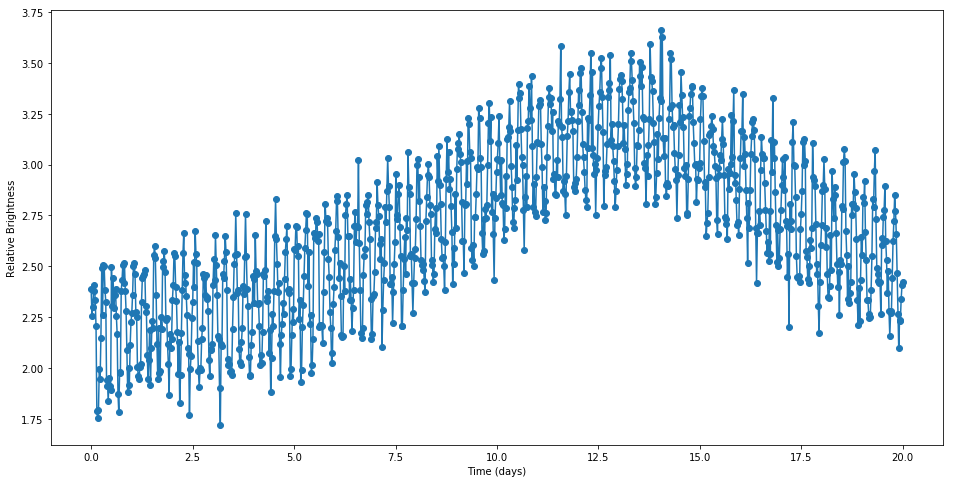

In [22]:
tm = np.linspace(0, 20, 1000)
amplitude_true = 0.3
fm = amplitude_true * np.sin(2 * np.pi * tm / 0.25 + 0.321)
def microlensing(t, v, impact, centertime):#where impact parameter is in units of the Einstein radius
    # and v is in units of Einstein radius/time
    u = np.sqrt(impact**2 + ((t - centertime) * v)**2)
    amp = (u**2 + 2)/(u * np.sqrt(u**2 + 4))
    return amp
fm = fm + microlensing(tm, .1, .5, 13)
fm = fm + np.random.normal(1, 0.1, len(tm))

fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(tm, fm,'o-', label = 'Data')
ax.set_ylabel('Relative Brightness')
ax.set_xlabel('Time (days)');